<div style="margin-bottom: 32px;">
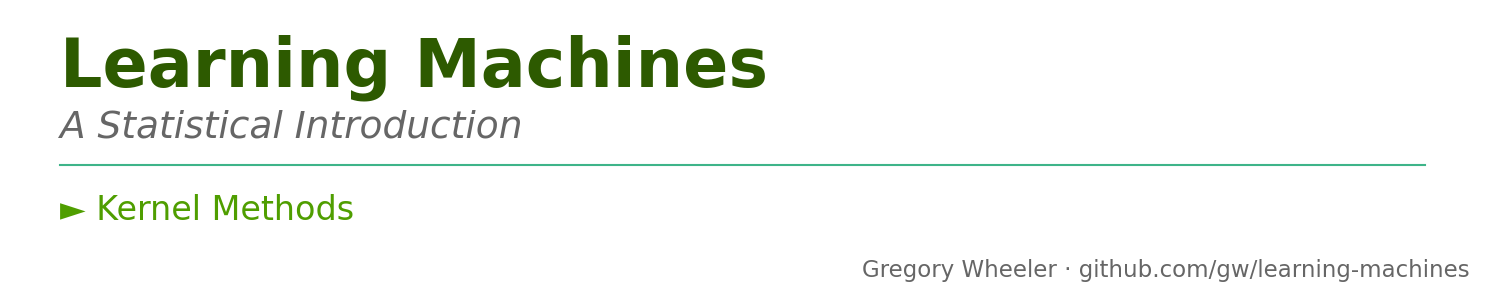
</div>


# Kernel Methods

Some patterns are not linearly separable in their original representation but become separable in a higher-dimensional space. The **kernel trick** lets us work in that space implicitly, without ever computing the transformation. This notebook makes kernels concrete: we see linear classifiers fail, watch kernels succeed, and visualize how the choice of kernel shapes the decision boundary.

**What computation adds**: Equations define kernel functions; here we see what they *do*—how an RBF kernel bends space to wrap around clusters, how polynomial kernels create curved boundaries, and what happens when kernel parameters are poorly chosen.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
from pathlib import Path

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

np.random.seed(42)

---
## 1. The Problem: Non-Linear Decision Boundaries

Many real datasets are not linearly separable. Let's create a classic example: the **XOR problem** and a **circular** dataset.

In [18]:
def make_circles_data(n_samples=200, noise=0.1, factor=0.5, seed=42):
    """Generate two concentric circles."""
    np.random.seed(seed)
    n_per_class = n_samples // 2
    
    # Outer circle (class 0)
    theta_outer = np.random.uniform(0, 2*np.pi, n_per_class)
    r_outer = 1.0 + np.random.normal(0, noise, n_per_class)
    X_outer = np.column_stack([r_outer * np.cos(theta_outer), 
                                r_outer * np.sin(theta_outer)])
    
    # Inner circle (class 1)
    theta_inner = np.random.uniform(0, 2*np.pi, n_per_class)
    r_inner = factor + np.random.normal(0, noise, n_per_class)
    X_inner = np.column_stack([r_inner * np.cos(theta_inner), 
                                r_inner * np.sin(theta_inner)])
    
    X = np.vstack([X_outer, X_inner])
    y = np.array([0]*n_per_class + [1]*n_per_class)
    
    return X, y

def make_xor_data(n_samples=200, noise=0.3, seed=42):
    """Generate XOR-like data."""
    np.random.seed(seed)
    n_per_quadrant = n_samples // 4
    
    # Class 0: top-left and bottom-right
    X0_tl = np.random.randn(n_per_quadrant, 2) * noise + [-1, 1]
    X0_br = np.random.randn(n_per_quadrant, 2) * noise + [1, -1]
    
    # Class 1: top-right and bottom-left
    X1_tr = np.random.randn(n_per_quadrant, 2) * noise + [1, 1]
    X1_bl = np.random.randn(n_per_quadrant, 2) * noise + [-1, -1]
    
    X = np.vstack([X0_tl, X0_br, X1_tr, X1_bl])
    y = np.array([0]*n_per_quadrant*2 + [1]*n_per_quadrant*2)
    
    return X, y

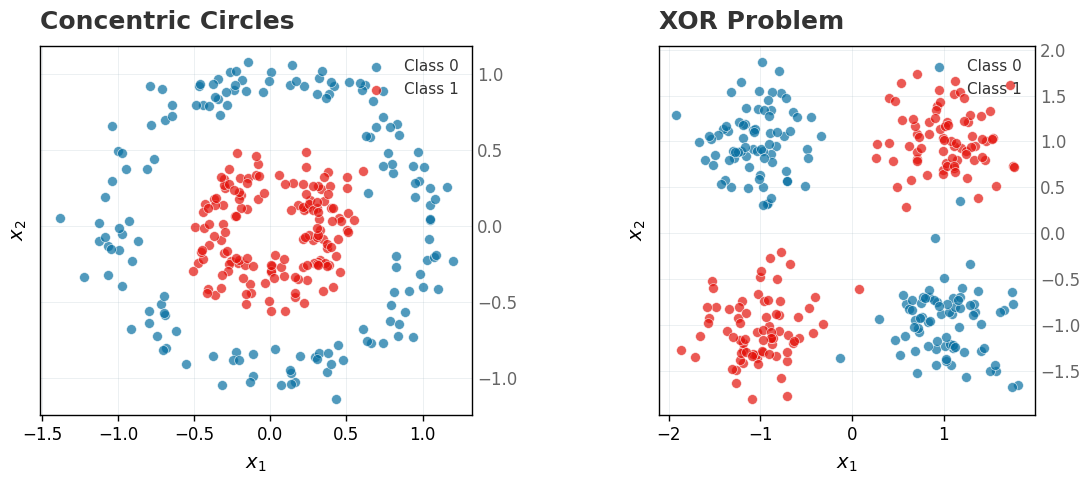

No straight line can separate either dataset.


In [19]:
# Generate both datasets
X_circles, y_circles = make_circles_data(300, noise=0.1, factor=0.4)
X_xor, y_xor = make_xor_data(300, noise=0.35)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Circles
ax = axes[0]
ax.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], 
           c=mt.BLUE, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 0')
ax.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
           c=mt.RED, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Concentric Circles', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

# XOR
ax = axes[1]
ax.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], 
           c=mt.BLUE, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 0')
ax.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], 
           c=mt.RED, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('XOR Problem', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("No straight line can separate either dataset.")

---
## 2. Linear Classifiers Fail

Let's confirm that a linear classifier (logistic regression) struggles with these datasets.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def plot_decision_boundary(ax, model, X, y, title):
    """Plot decision boundary for a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([mt.BLUE, mt.RED]))
    ax.contour(xx, yy, Z, colors='black', linewidths=1, alpha=0.5)
    
    ax.scatter(X[y==0, 0], X[y==0, 1], c=mt.BLUE, s=40, alpha=0.7, 
               edgecolors='white', linewidths=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c=mt.RED, s=40, alpha=0.7,
               edgecolors='white', linewidths=0.5)
    
    acc = model.score(X, y)
    ax.set_title(f'{title}\nAccuracy: {acc:.1%}', fontweight='bold', loc='left')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

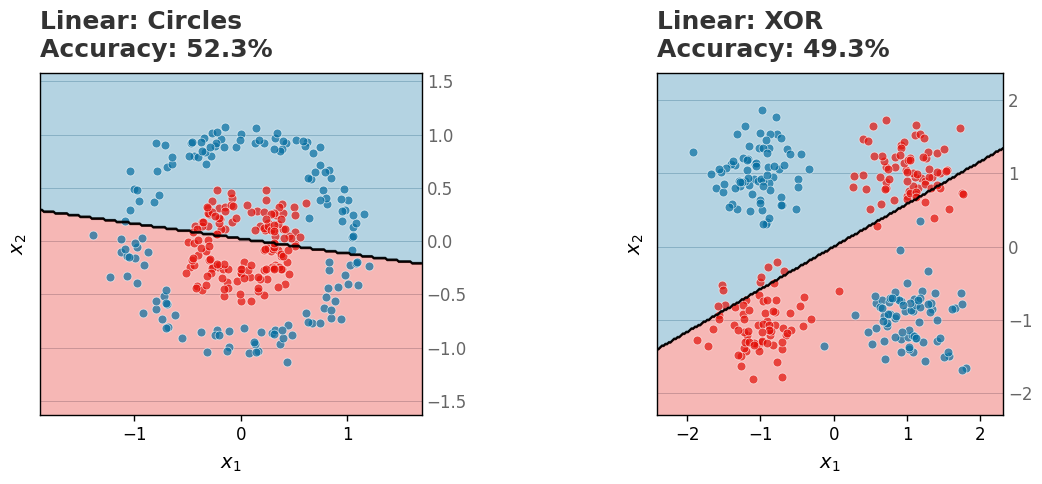

Linear classifiers achieve ~50% accuracy—no better than random guessing.


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear classifier on circles
lr_circles = LogisticRegression()
lr_circles.fit(X_circles, y_circles)
plot_decision_boundary(axes[0], lr_circles, X_circles, y_circles, 'Linear: Circles')

# Linear classifier on XOR
lr_xor = LogisticRegression()
lr_xor.fit(X_xor, y_xor)
plot_decision_boundary(axes[1], lr_xor, X_xor, y_xor, 'Linear: XOR')

for ax in axes:
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

print("Linear classifiers achieve ~50% accuracy—no better than random guessing.")

---
## 3. The Feature Space Idea

What if we transform the data into a space where it *is* linearly separable?

For the circles data, consider the transformation $\phi(x_1, x_2) = x_1^2 + x_2^2$ (the squared distance from the origin). In this 1D space, the classes become nearly separable—a simple threshold achieves near-perfect classification.

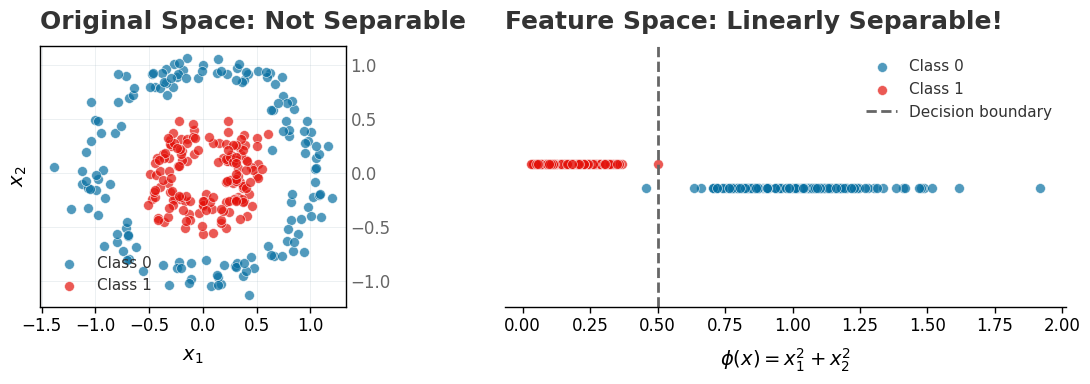

In [22]:
# Transform circles data
r_squared = X_circles[:, 0]**2 + X_circles[:, 1]**2

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original space
ax = axes[0]
ax.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], 
           c=mt.BLUE, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 0')
ax.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
           c=mt.RED, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original Space: Not Separable', fontweight='bold', loc='left')
ax.legend()
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

# Transformed space
ax = axes[1]
ax.scatter(r_squared[y_circles==0], np.zeros(sum(y_circles==0)), 
           c=mt.BLUE, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 0')
ax.scatter(r_squared[y_circles==1], np.zeros(sum(y_circles==1)) + 0.1, 
           c=mt.RED, s=50, alpha=0.7, edgecolors='white', linewidths=0.5, label='Class 1')

# Decision boundary
threshold = 0.5
ax.axvline(x=threshold, color=mt.GRAY, linestyle='--', linewidth=2, label='Decision boundary')

ax.set_xlabel('$\\phi(x) = x_1^2 + x_2^2$')
ax.set_ylabel('')
ax.set_title('Feature Space: Linearly Separable!', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_ylim(-0.5, 0.6)
ax.set_yticks([])
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

The transformation $\phi$ maps data to a **feature space** where a linear classifier works.

**Problem**: For complex patterns, we might need very high-dimensional (even infinite-dimensional) feature spaces. Computing $\phi(x)$ explicitly becomes expensive or impossible.

---
## 4. The Kernel Trick

The **kernel trick** is the key insight: many algorithms only need **dot products** between data points, not the features themselves.

A **kernel function** computes the dot product in feature space directly:

$$k(x, x') = \langle \phi(x), \phi(x') \rangle$$

We never compute $\phi(x)$—we just use $k(x, x')$.

### Common Kernels

| Kernel | Formula | Feature Space |
|--------|---------|---------------|
| Linear | $k(x, x') = x^T x'$ | Original space |
| Polynomial | $k(x, x') = (x^T x' + c)^d$ | All monomials up to degree $d$ |
| RBF (Gaussian) | $k(x, x') = \exp(-\gamma \|x - x'\|^2)$ | Infinite-dimensional |

In [23]:
def linear_kernel(x1, x2):
    """Linear kernel: k(x, x') = x^T x'"""
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3, c=1):
    """Polynomial kernel: k(x, x') = (x^T x' + c)^d"""
    return (np.dot(x1, x2) + c) ** degree

def rbf_kernel(x1, x2, gamma=1.0):
    """RBF (Gaussian) kernel: k(x, x') = exp(-gamma ||x - x'||^2)"""
    return np.exp(-gamma * np.sum((x1 - x2) ** 2))

In [24]:
# Demonstrate kernel values
x1 = np.array([1.0, 0.0])
x2 = np.array([0.0, 1.0])
x3 = np.array([1.0, 0.1])  # Close to x1

print("Kernel values for sample points:")
print(f"x1 = {x1}, x2 = {x2}, x3 = {x3}")
print()
print(f"Linear kernel:")
print(f"  k(x1, x1) = {linear_kernel(x1, x1):.3f}")
print(f"  k(x1, x2) = {linear_kernel(x1, x2):.3f}  (orthogonal)")
print(f"  k(x1, x3) = {linear_kernel(x1, x3):.3f}  (similar)")
print()
print(f"RBF kernel (γ=1):")
print(f"  k(x1, x1) = {rbf_kernel(x1, x1):.3f}  (identical)")
print(f"  k(x1, x2) = {rbf_kernel(x1, x2):.3f}  (far apart)")
print(f"  k(x1, x3) = {rbf_kernel(x1, x3):.3f}  (close)")

Kernel values for sample points:
x1 = [1. 0.], x2 = [0. 1.], x3 = [1.  0.1]

Linear kernel:
  k(x1, x1) = 1.000
  k(x1, x2) = 0.000  (orthogonal)
  k(x1, x3) = 1.000  (similar)

RBF kernel (γ=1):
  k(x1, x1) = 1.000  (identical)
  k(x1, x2) = 0.135  (far apart)
  k(x1, x3) = 0.990  (close)


The RBF kernel measures **similarity**: identical points have $k(x,x) = 1$, and similarity decays exponentially with distance.

---
## 5. Support Vector Machines with Kernels

**Support Vector Machines (SVMs)** are the classic algorithm that exploits the kernel trick. The decision function only depends on dot products:

$$f(x) = \sum_{i \in SV} \alpha_i y_i k(x_i, x) + b$$

where $SV$ is the set of **support vectors**—the training points closest to the decision boundary.

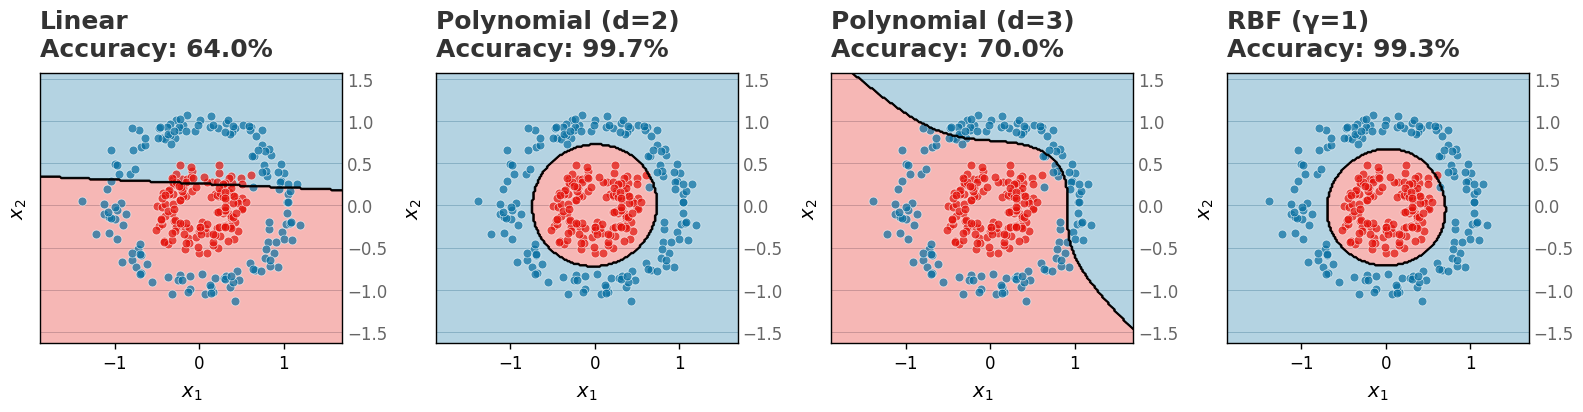

In [25]:
from sklearn.svm import SVC

# Compare kernels on the circles dataset
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

kernels = [
    ('linear', {}),
    ('poly', {'degree': 2}),
    ('poly', {'degree': 3}),
    ('rbf', {'gamma': 1.0}),
]
titles = ['Linear', 'Polynomial (d=2)', 'Polynomial (d=3)', 'RBF (γ=1)']

for ax, (kernel, params), title in zip(axes, kernels, titles):
    svm = SVC(kernel=kernel, **params)
    svm.fit(X_circles, y_circles)
    plot_decision_boundary(ax, svm, X_circles, y_circles, title)
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

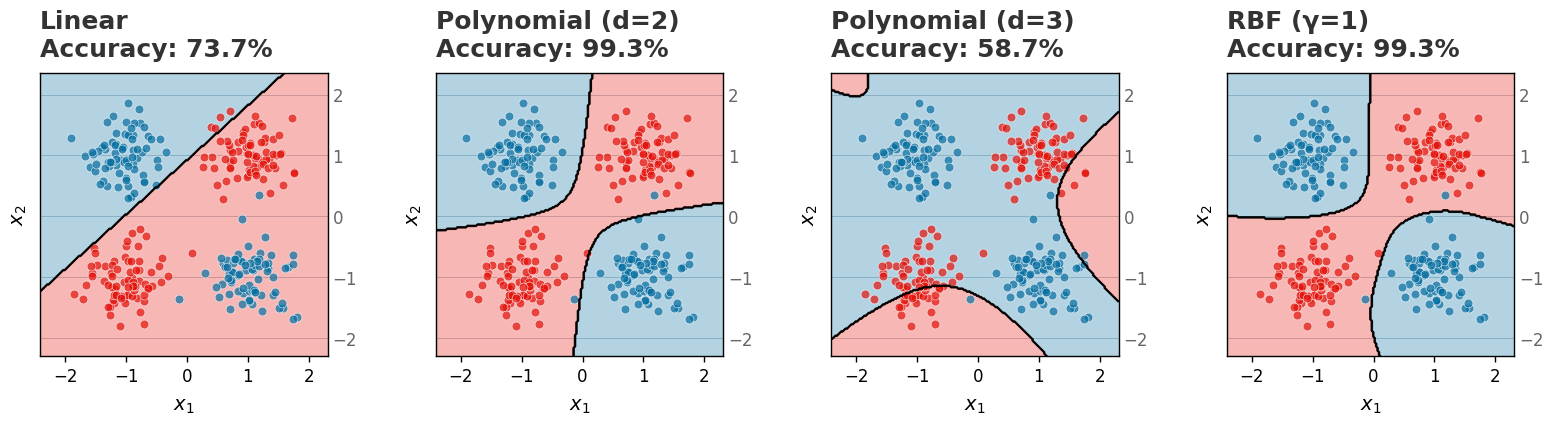

In [26]:
# Same comparison for XOR
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (kernel, params), title in zip(axes, kernels, titles):
    svm = SVC(kernel=kernel, **params)
    svm.fit(X_xor, y_xor)
    plot_decision_boundary(ax, svm, X_xor, y_xor, title)
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

The RBF kernel handles both datasets well, creating flexible decision boundaries that wrap around the data.

---
## 6. Visualizing Support Vectors

Support vectors are the critical training points that define the decision boundary. The SVM solution only depends on these points—other training data can be removed without changing the model.

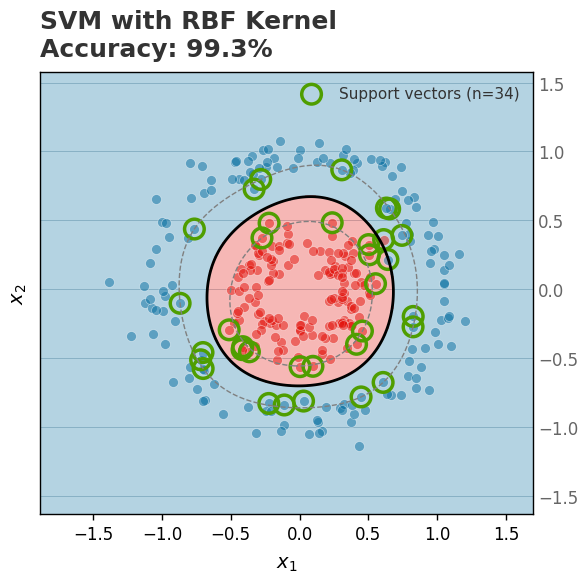

Total training points: 300
Support vectors: 34 (11.3%)


In [27]:
def plot_svm_with_support_vectors(X, y, kernel='rbf', gamma=1.0, C=1.0):
    """Plot SVM decision boundary with support vectors highlighted."""
    svm = SVC(kernel=kernel, gamma=gamma, C=C)
    svm.fit(X, y)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Filled contours for classes
    ax.contourf(xx, yy, Z > 0, alpha=0.3, cmap=ListedColormap([mt.BLUE, mt.RED]))
    
    # Decision boundary and margins
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['gray', 'black', 'gray'],
               linestyles=['--', '-', '--'], linewidths=[1, 2, 1])
    
    # All points
    ax.scatter(X[y==0, 0], X[y==0, 1], c=mt.BLUE, s=50, alpha=0.5,
               edgecolors='white', linewidths=0.5)
    ax.scatter(X[y==1, 0], X[y==1, 1], c=mt.RED, s=50, alpha=0.5,
               edgecolors='white', linewidths=0.5)
    
    # Highlight support vectors
    sv = svm.support_vectors_
    ax.scatter(sv[:, 0], sv[:, 1], s=200, facecolors='none', 
               edgecolors=mt.GREEN, linewidths=2.5, label=f'Support vectors (n={len(sv)})')
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'SVM with {kernel.upper()} Kernel\nAccuracy: {svm.score(X, y):.1%}',
                 fontweight='bold', loc='left')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    
    plt.tight_layout()
    return svm

svm_circles = plot_svm_with_support_vectors(X_circles, y_circles, kernel='rbf', gamma=2.0)
plt.show()

print(f"Total training points: {len(y_circles)}")
print(f"Support vectors: {len(svm_circles.support_vectors_)} ({len(svm_circles.support_vectors_)/len(y_circles):.1%})")

---
## 7. The Effect of the RBF Parameter γ

The RBF kernel has a parameter $\gamma$ that controls how "local" the similarity measure is:

- **Small γ**: Each point influences a large region → smoother boundary
- **Large γ**: Each point only affects nearby points → more complex boundary

This is the **bias-variance tradeoff** in kernel space.

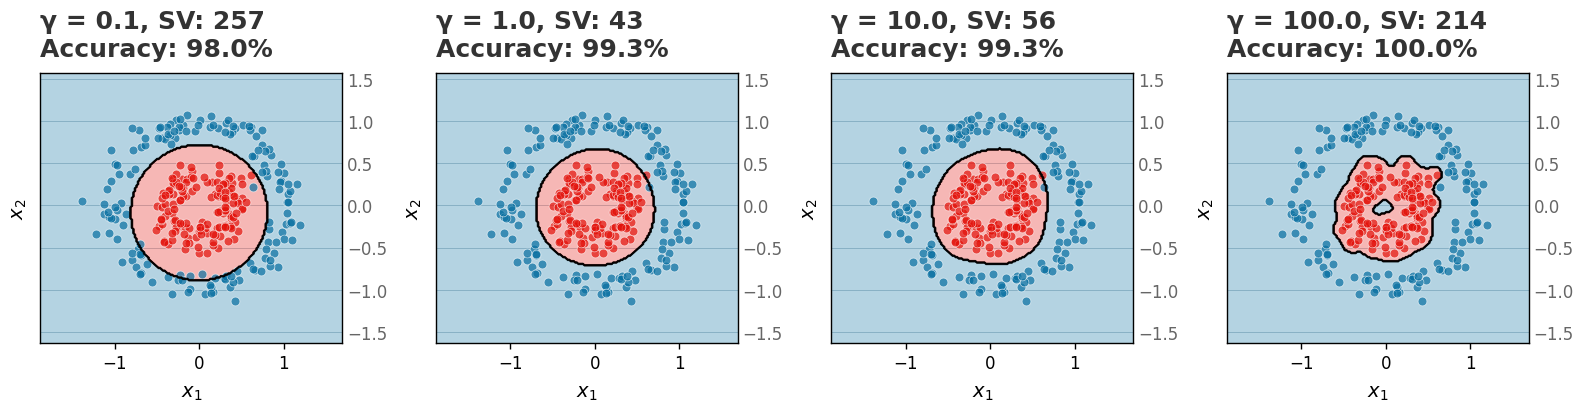

In [28]:
# Effect of gamma
gammas = [0.1, 1.0, 10.0, 100.0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, gamma in zip(axes, gammas):
    svm = SVC(kernel='rbf', gamma=gamma)
    svm.fit(X_circles, y_circles)
    n_sv = len(svm.support_vectors_)
    plot_decision_boundary(ax, svm, X_circles, y_circles, f'γ = {gamma}, SV: {n_sv}')
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

**Observations:**
- **γ = 0.1**: Underfitting—boundary is too smooth
- **γ = 1.0**: Good fit—captures the circular structure
- **γ = 10, 100**: Overfitting—boundary becomes jagged, wrapping tightly around individual points

Note how the number of support vectors increases with γ—a sign of overfitting.

---
## 8. The Regularization Parameter C

SVMs also have a regularization parameter $C$:

- **Small C**: More regularization → wider margins, more misclassifications allowed
- **Large C**: Less regularization → narrower margins, tries to classify all training points correctly

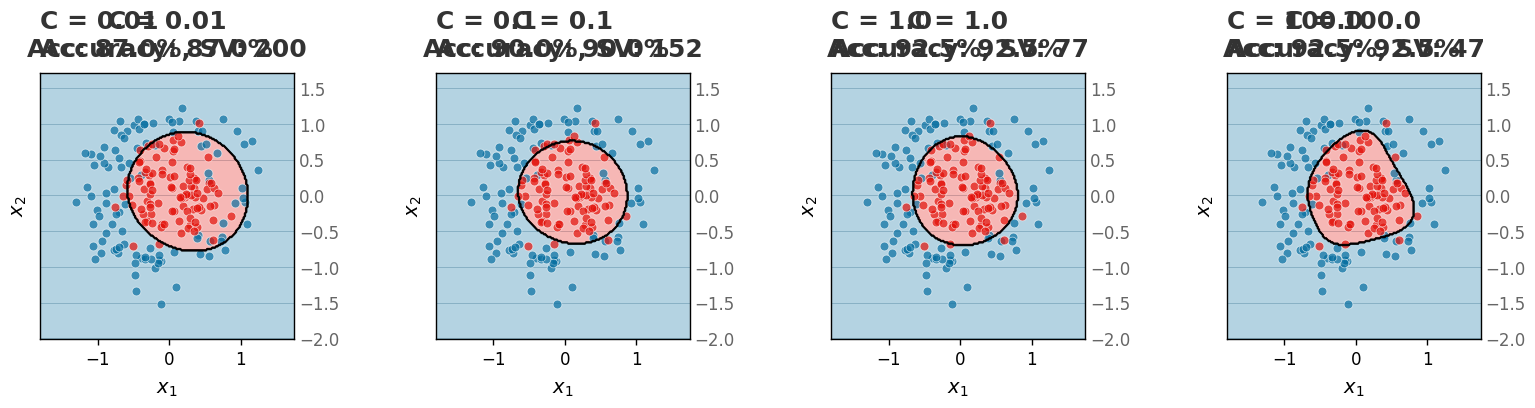

In [29]:
# Generate noisier data to show C effect
X_noisy, y_noisy = make_circles_data(200, noise=0.2, factor=0.5, seed=123)

C_values = [0.01, 0.1, 1.0, 100.0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, C in zip(axes, C_values):
    svm = SVC(kernel='rbf', gamma=1.0, C=C)
    svm.fit(X_noisy, y_noisy)
    n_sv = len(svm.support_vectors_)
    plot_decision_boundary(ax, svm, X_noisy, y_noisy, f'C = {C}, SV: {n_sv}')
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

plt.tight_layout()
plt.show()

With noisy data:
- **Small C**: Ignores some misclassified points for a smoother boundary
- **Large C**: Tries to get every point right, potentially overfitting to noise

---
## 9. Kernel PCA: Beyond Classification

Kernels aren't just for SVMs. **Kernel PCA** performs dimensionality reduction in the feature space, finding nonlinear structure.

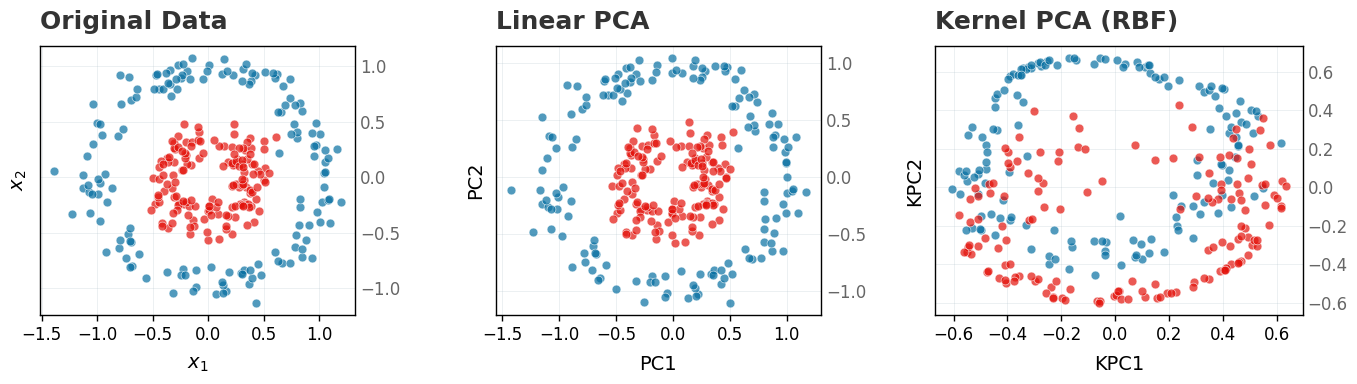

Linear PCA can't separate the circles.
Kernel PCA projects to a space where they're separable.


In [30]:
from sklearn.decomposition import PCA, KernelPCA

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original data
ax = axes[0]
ax.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], 
           c=mt.BLUE, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
           c=mt.RED, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.set_title('Original Data', fontweight='bold', loc='left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

# Linear PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_circles)

ax = axes[1]
ax.scatter(X_pca[y_circles==0, 0], X_pca[y_circles==0, 1], 
           c=mt.BLUE, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.scatter(X_pca[y_circles==1, 0], X_pca[y_circles==1, 1], 
           c=mt.RED, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.set_title('Linear PCA', fontweight='bold', loc='left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

# Kernel PCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=2.0)
X_kpca = kpca.fit_transform(X_circles)

ax = axes[2]
ax.scatter(X_kpca[y_circles==0, 0], X_kpca[y_circles==0, 1], 
           c=mt.BLUE, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.scatter(X_kpca[y_circles==1, 0], X_kpca[y_circles==1, 1], 
           c=mt.RED, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.set_title('Kernel PCA (RBF)', fontweight='bold', loc='left')
ax.set_xlabel('KPC1')
ax.set_ylabel('KPC2')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Linear PCA can't separate the circles.")
print("Kernel PCA projects to a space where they're separable.")

---
## 10. Choosing Hyperparameters with Cross-Validation

Both γ and C must be tuned. Grid search with cross-validation is the standard approach.

In [31]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

# Grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.1%}")
print(f"Test accuracy: {grid_search.score(X_test, y_test):.1%}")

Best parameters: {'C': 1, 'gamma': 1}
Best CV accuracy: 100.0%
Test accuracy: 98.9%


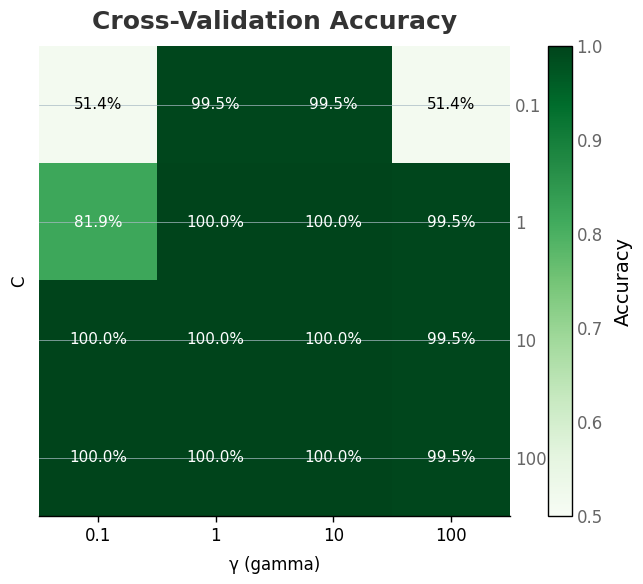

In [32]:
# Visualize the grid search results
results = grid_search.cv_results_
scores = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(scores, cmap='Greens', vmin=0.5, vmax=1.0)

ax.set_xticks(range(len(param_grid['gamma'])))
ax.set_yticks(range(len(param_grid['C'])))
ax.set_xticklabels(param_grid['gamma'])
ax.set_yticklabels(param_grid['C'])
ax.set_xlabel('γ (gamma)', fontsize=12)
ax.set_ylabel('C', fontsize=12)
ax.set_title('Cross-Validation Accuracy', fontweight='bold')

# Add text annotations
for i in range(len(param_grid['C'])):
    for j in range(len(param_grid['gamma'])):
        text = f'{scores[i, j]:.1%}'
        color = 'white' if scores[i, j] > 0.8 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=11, color=color)

plt.colorbar(im, ax=ax, label='Accuracy')
plt.tight_layout()
plt.show()

---
## Summary

**The kernel trick:**
- Maps data to a higher-dimensional feature space where linear methods work
- Computes dot products in feature space without explicit transformation
- Enables flexible, nonlinear decision boundaries

**Common kernels:**

| Kernel | When to use |
|--------|-------------|
| Linear | When data is already linearly separable |
| Polynomial | When polynomial features would help |
| RBF | General-purpose; good default choice |

**Key hyperparameters (for RBF SVM):**
- **γ**: Controls locality of similarity. Small = smooth, large = complex
- **C**: Regularization. Small = wider margin (more regularization), large = narrower margin

**Beyond SVMs:**
- Kernel PCA for nonlinear dimensionality reduction
- Kernel regression, kernel k-means, and more

**Historical note:** SVMs with kernels were state-of-the-art for many tasks before deep learning. They remain useful for smaller datasets and when interpretability matters.

---
## Exploration

Try modifying:
- **Different datasets**: How does the RBF kernel handle the moons dataset (`sklearn.datasets.make_moons`)?
- **Kernel comparison**: Which kernel works best for your own data?
- **Feature scaling**: What happens if you don't standardize features before using RBF?
- **Real data**: Apply kernel SVM to a real dataset like the Iris or Wine datasets.